#### data cleansing, EDA, model creation
 - POS_CASH_balance, installments_payments, credit_card_balance 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##### load dataset under colab

In [13]:
import os, sys

In [14]:
default_dir = "../home-credit-default-risk/"

##### column data type convert to reduce memory allocated size

In [15]:
def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }
    
    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }
    
    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }
        
    pos_bal = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'), dtype=pos_dtype)
    install = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'), dtype=install_dtype)
    card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)
    
    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [10]:
pos_bal.shape, install.shape, card_bal.shape

((10001358, 8), (13605401, 8), (3840312, 23))

#### load package

In [16]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

#### EDA , Feature Engineering

In [18]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

def get_prev_processed(prev):
  """
  feature engineering 
  for previouse application credit history
  """
  prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
  prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
  # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
  prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
  
  # Data Cleansing
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

  # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
  prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  
  # 1.Calculate the interest rate
  all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
      
  return prev
    
    
def get_prev_amt_agg(prev):
  """
  feature engineering for the previous credit appliction
  """
  # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
  agg_dict = {
        # 기존 컬럼 aggregation. 
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      # 가공 컬럼 aggregation
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
  }

  prev_group = prev.groupby('SK_ID_CURR')
  prev_amt_agg = prev_group.agg(agg_dict)

  # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
  prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
  
  return prev_amt_agg

def get_prev_refused_appr_agg(prev):
  """
  PREV_APPROVED_COUNT : Credit application approved count
  PREV_REFUSED_COUNT :  Credit application refused count
  """
  prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
  # unstack() 
  prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

  # rename column 
  prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
  
  # NaN값은 모두 0으로 변경. 
  prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
  
  return prev_refused_appr_agg

#### DAYS_DECISION이 -365일 이전 데이터 세트 추가 가공. 

def get_prev_days365_agg(prev):
  """
  DAYS_DESCISION means How many days have been take since the previous credit application made.
  Somewhat this feature is important.
  """
  cond_days365 = prev['DAYS_DECISION'] > -365
  prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
  agg_dict = {
        # 기존 컬럼 aggregation. 
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      # 가공 컬럼 aggregation
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
  }
  
  prev_days365_agg = prev_days365_group.agg(agg_dict)

  # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
  prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]
  
  return prev_days365_agg
    
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    # 연체 여부 및 120일 이상 연체 여부 가공
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau


def get_bureau_day_amt_agg(bureau):
  '''
  bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성 
  '''      
  bureau_agg_dict = {
  'SK_ID_BUREAU':['count'],
  'DAYS_CREDIT':['min', 'max', 'mean'],
  'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
  'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
  'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
  'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
  'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
  'AMT_ANNUITY': ['max', 'mean', 'sum'],
  # 추가 가공 컬럼
  'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
  'BUREAU_IS_DPD':['mean', 'sum'],
  'BUREAU_IS_DPD_OVER120':['mean', 'sum']
  }

  bureau_grp = bureau.groupby('SK_ID_CURR')
  bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
  bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
  # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
  bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
  #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
  return bureau_day_amt_agg


def get_bureau_active_agg(bureau):
  '''
  Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 
  주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
  '''
  # CREDIT_ACTIVE='Active' 인 데이터만 filtering
  cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
  bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
  bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],
      # 추가 가공 컬럼
      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

  bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
  bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
  # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
  bureau_active_agg = bureau_active_agg.reset_index()
  #print('bureau_active_agg shape:', bureau_active_agg.shape)
  return bureau_active_agg

# BUREAU의 DAYS_CREDIT 가 -750보다 최근 데이터 별도 가공. 
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg


# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR레벨로 Group by하기 위해 bureau에서 SK_ID_CURR 컬럼을 가져오는 조인 수행. 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS에 따라 월별 연체 여부 및 120일 이상 연체 여부 속성 가공. 
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg와 bureau_active_agg 조인.  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS가 ACTIVE IS_DPD RATIO관련 비율 재가공. 
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg와 bureau_bal_agg 조인. 
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

#### aggregation for pos, install, credit card

In [19]:
def get_pos_bal_agg(pos_bal):
    # 연체 일자(SK_DPD)가 0 보다 큰 경우, 0~ 100 사이, 100보다 큰 경우 조사 
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    # 컬럼명 변경 
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE가 최근(20개월 이하)인 데이터 세트 별도 가공. 
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)
    # 컬럼 변경 
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

def get_install_agg(install):
    # 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 예정 납부 일자 대비 실제 납부 일자 비교를 DPD 일자 생성  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 연체여부,  연체일수 30~ 120 사이 여부, 연체 일수 100보다 큰 여부 데이터 가공. 
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성. 
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # 실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

def get_card_bal_agg(card_bal):
    # 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD에 따른 가공 컬럼 생성.
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        #  추가 컬럼
        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공.  
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

#### datasets concatenation and Join

In [20]:
# apps와 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 개별 함수 호출하여 생성후 조인 결합
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
  """
  Description :
  1.Data preparation , aggregation 
  2.produce the finalized result
  """
  apps_all =  get_apps_processed(apps)
  prev_agg = get_prev_agg(prev)
  bureau_agg = get_bureau_agg(bureau, bureau_bal)
  pos_bal_agg = get_pos_bal_agg(pos_bal)
  install_agg = get_install_agg(install)
  card_bal_agg = get_card_bal_agg(card_bal)
  print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
  print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
  print('apps_all before merge shape:', apps_all.shape)
  
  # Join with apps_all
  apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')
    
  print('apps_all after merge with all shape:', apps_all.shape)
  
  return apps_all

#### reload the original *datasets*

In [21]:
def get_dataset():
  """
  load datasets
  1.app_train - train dataset 
  2.app_test - test datasets
  3.apps - concatenated app_train, app_test
  4.pos_bal - POS_CACHE
  5.install - installments_payments
  6.card_bal - Credit Card
  """
  app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
  app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))
  apps = pd.concat([app_train, app_test])
  
  prev = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
  bureau = pd.read_csv(os.path.join(default_dir,'bureau.csv'))
  bureau_bal = pd.read_csv(os.path.join(default_dir,'bureau_balance.csv'))
  
  pos_bal, install, card_bal = get_balance_data()
      
  return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

In [22]:
apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

#### Data preparation, encodeing, datasets split, fit

In [23]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)


# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 
clf = train_apps_all(apps_all_train)
'''
Private Score:0.79033 Public Score:0.79920
'''

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 135)
apps_all after merge with all shape: (356255, 534)
train shape: (215257, 532) valid shape: (92254, 532)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798096	training's binary_logloss: 0.238337	valid_1's auc: 0.770583	valid_1's binary_logloss: 0.244916
[200]	training's auc: 0.821732	training's binary_logloss: 0.226589	valid_1's auc: 0.782339	valid_1's binary_logloss: 0.239014
[300]	training's auc: 0.838886	training's binary_logloss: 0.218872	valid_1's auc: 0.787892	valid_1's binary_logloss: 0.236685
[400]	training's auc: 0.852944	training's binary_logloss: 0.212656	valid_1's auc: 0.79065	valid_1's binary_logloss: 0.235579
[500]	training's 

'\nPrivate Score:0.79033 Public Score:0.79920\n'

#### CSV for Predicted result

In [24]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'pos_install_credit_02.csv'), index=False)

In [2]:
from IPython.display import Image

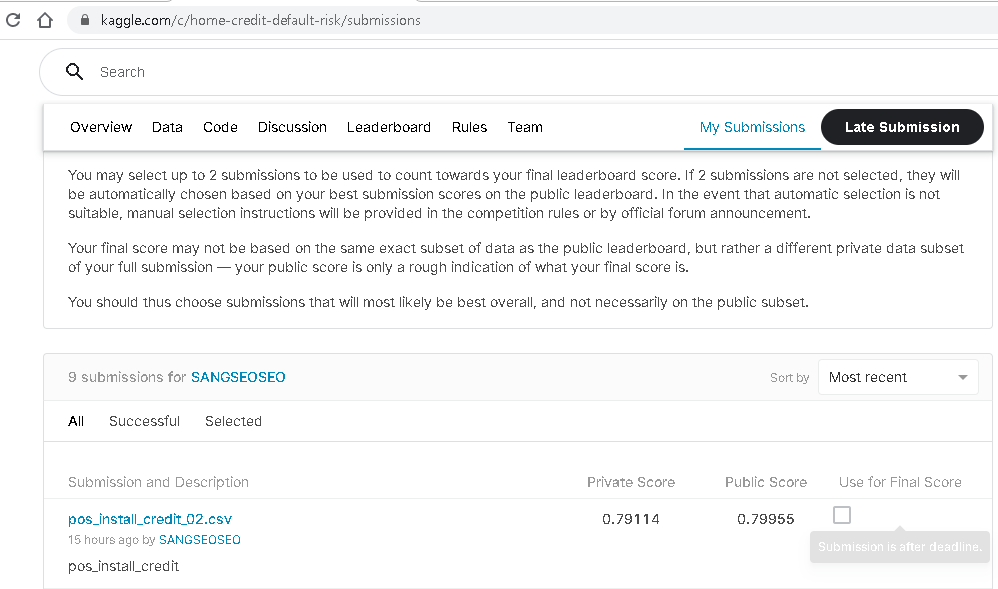

In [3]:
Image("../HomeCreditDefaultRisk/Home Credit Default Risk_20210331.PNG")